# Import package and module

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

In [14]:
tf.config.list_physical_devices("GPU")
!nvidia-smi

Thu May 12 14:42:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:29:00.0  On |                  N/A |
| 40%   49C    P8    20W / 125W |    956MiB /  6144MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load path

In [11]:
try:
    set_pick = int(input("Dataset : \n1. Kaggle\n2. Mendley"))
    if set_pick == 1:
        # Dataset dir
        train_dir = './cigarette-smoker-detection-kaggle/train'
        test_dir = './cigarette-smoker-detection-kaggle/test'

        print("Kaggle dataset selected")

    elif set_pick == 2:
        # Dataset dir 
        train_dir = './dataset_mendley/training_data'
        val_dir = './dataset_mendley/validation_data'
        test_dir = './dataset_mendley/testing_data'
        
        print("Mendley dataset selected")
    else:
        raise Exception("Input 1 or 2")
except ValueError:
    print("Wrong input value!!!")

Mendley dataset selected


# Preprocessing

### Preprocessing

In [16]:
img_size = 224
batch_size = 32
seed = 72

if set_pick == 1:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

elif set_pick == 2:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 1610 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [17]:
train_ds.class_names

['notsmoking', 'smoking']

## Rescale

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
print("\nRescale Successful")


Rescale Successful


# Train

In [19]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(img_size, img_size, 3),
    weights="imagenet",
    include_preprocessing=False,
    include_top=False,
    pooling="avg"
)

base_model.trainable = False

In [20]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(units=1, activation = "sigmoid")
])

In [21]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

Model Summary

In [22]:
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Start train

In [23]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

print("\n==========================")
print("======= Train done =======")
print("==========================")

Epoch 1/300
51/51 [==============================] - 21s 236ms/step - loss: 0.5397 - accuracy: 0.7261 - precision: 0.7203 - recall: 0.7391 - val_loss: 0.3844 - val_accuracy: 0.8300 - val_precision: 0.8204 - val_recall: 0.8450
Epoch 2/300
51/51 [==============================] - 8s 139ms/step - loss: 0.3532 - accuracy: 0.8584 - precision: 0.8685 - recall: 0.8447 - val_loss: 0.3354 - val_accuracy: 0.8450 - val_precision: 0.8632 - val_recall: 0.8200
Epoch 3/300
51/51 [==============================] - 8s 139ms/step - loss: 0.3019 - accuracy: 0.8801 - precision: 0.8844 - recall: 0.8745 - val_loss: 0.3165 - val_accuracy: 0.8550 - val_precision: 0.8901 - val_recall: 0.8100
Epoch 4/300
51/51 [==============================] - 8s 140ms/step - loss: 0.2671 - accuracy: 0.8950 - precision: 0.9015 - recall: 0.8870 - val_loss: 0.3051 - val_accuracy: 0.8600 - val_precision: 0.8956 - val_recall: 0.8150
Epoch 5/300
51/51 [==============================] - 8s 140ms/step - loss: 0.2456 - accuracy: 0.911

Result #1 train

In [24]:
acc = history_1.history['accuracy']
prec = history_1.history['precision']
recall = history_1.history['recall']
loss = history_1.history['loss']

val_acc = history_1.history['val_accuracy']
val_prec = history_1.history['val_precision']
val_recall = history_1.history['val_recall']
val_loss = history_1.history['val_loss']

In [25]:
save_path = './Developed-model/exp5'
model.save(save_path)
print("\nModel has been saved")

INFO:tensorflow:Assets written to: ./Developed-model/exp5\assets


INFO:tensorflow:Assets written to: ./Developed-model/exp5\assets



Model has been saved


In [26]:
print("\nEvaluating the model with test set")
model.evaluate(test_ds)


Evaluating the model with test set
13/13 [==============================] - 5s 126ms/step - loss: 0.2942 - accuracy: 0.9475 - precision: 0.9453 - recall: 0.9500


[0.2942034602165222, 0.9474999904632568, 0.9452736377716064, 0.949999988079071]

# Export Fine tune 1 metrics result to csv

In [27]:
data = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
export_data = zip_longest(*data, fillvalue = '')

with open('exp5.csv', 'w', encoding="ISO-8859-1", newline='') as file:
      write = csv.writer(file)
      write.writerow(("acc", "prec", "recall", "loss", "val_acc", "val_prec", "val_recall", "val_loss"))
      write.writerows(export_data)

print("\nTrain result has been saved")


Train result has been saved


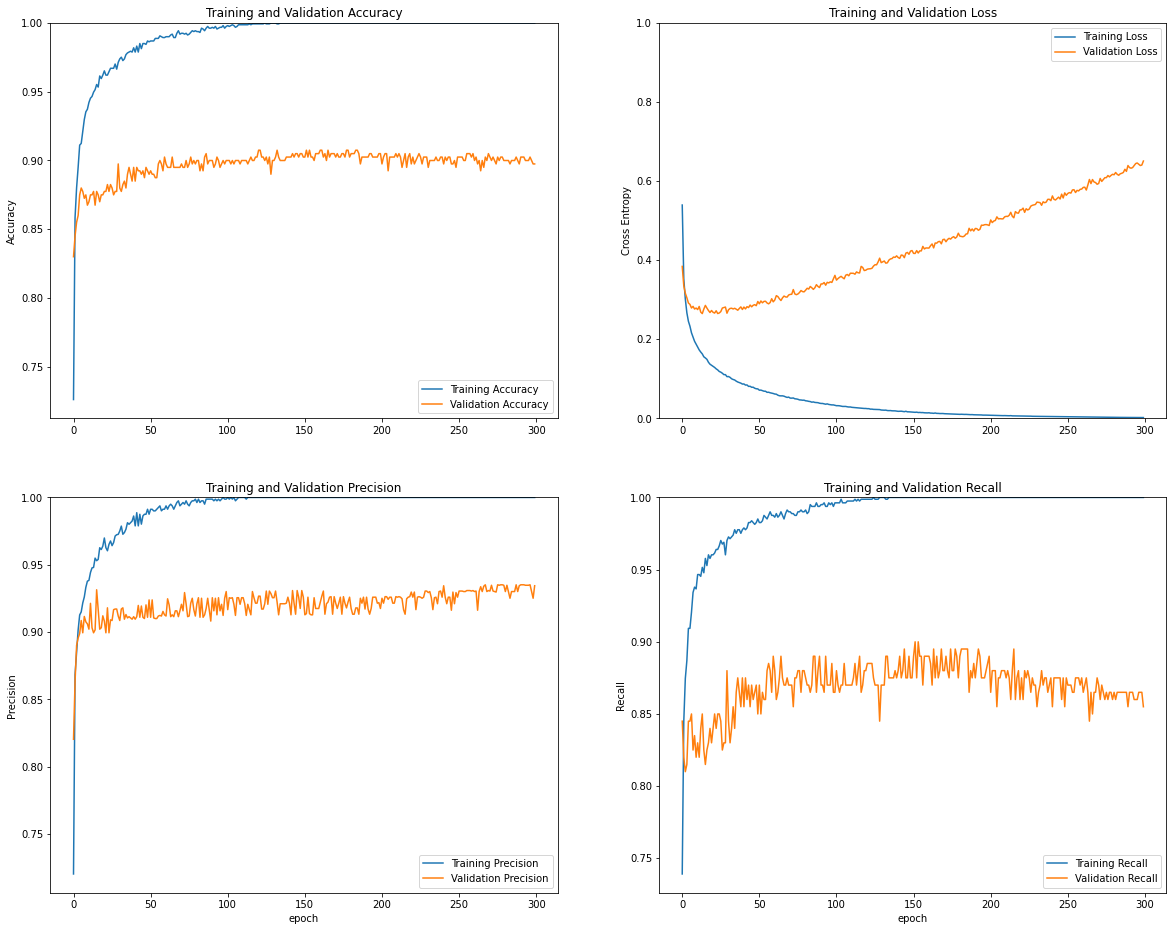

In [28]:


plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()